In [109]:
import numpy as np
import nengo
import nengo.spa as spa
import world
import kitchen
import nodes
import matplotlib.pyplot as plt
%matplotlib inline

D = 256

test_world = kitchen.get_kitchen()
test_world.print_state()

effects = ['WATER_IN_KETTLE', 'KETTLE_UNDER_TAP', 'WATER_BOILED', 'KETTLE_PLUGGED_IN', 'KETTLE_UNPLUGGED', 'KETTLE']
action_set = ['FILL_KETTLE_FROM_TAP', 'PUT_KETTLE_UNDER_TAP', 'BOIL_KETTLE', 'PLUG_IN_KETTLE','UNPLUG_KETTLE','KETTLE']
precons = ['KETTLE_UNDER_TAP','KETTLE_UNPLUGGED','WATER_IN_KETTLE','HAS_CORD']

switches = ['PLAN','EXECUTE']

effect_vocab = spa.Vocabulary(D)
action_vocab = spa.Vocabulary(D)
precon_vocab = spa.Vocabulary(D)

for effect in effects:
    effect_vocab.parse(effect)
    
for action in action_set:
    action_vocab.parse(action)

for precon in precons:
    precon_vocab.parse(precon)  

action_vocab['INDEX'].make_unitary()

switch_vocab = spa.Vocabulary(D)
switch_vocab.parse('PLAN')
switch_vocab.parse('EXECUTE')
switch_vocab.parse('NULL')

mapping = np.zeros((D, len(action_vocab.keys)))

mapping[:,0] = switch_vocab['NULL'].v
mapping[:,1] = switch_vocab['NULL'].v
mapping[:,2] = switch_vocab['NULL'].v
mapping[:,3] = switch_vocab['NULL'].v
mapping[:,4] = switch_vocab['EXECUTE'].v
mapping[:,5] = switch_vocab['NULL'].v

WATER
{'TEMPERATURE': 'COLD'}
------------------
KETTLE
{'PLUGGED': 'PLUGGED_IN'}
ON-COUNTER
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


In [110]:
from nengo.networks import AssociativeMemory 

motor_sys = nodes.MotorSystem(action_vocab, test_world)
vision_sys = nodes.VisualSystem(precon_vocab, test_world)

with spa.SPA(label='Planner Test') as model:

    # For managing control signals
    model.ctrl = spa.Memory(dimensions=D, tau=0.05) 
    model.switch = spa.Memory(dimensions=D, vocab=switch_vocab, tau=0.02)
    
    model.m_goal = spa.Memory(dimensions=D, vocab=effect_vocab)
    model.i_goal = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.005, tau=0.05)
    model.action = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.05)
    model.precon = spa.Memory(dimensions=D, vocab=precon_vocab, synapse=0.005, tau=0.05)

    model.action_to_precon = spa.AssociativeMemory(input_vocab=action_vocab, output_vocab=precon_vocab, 
                                                   input_keys=action_set[:4], output_keys=precons, 
                                                   threshold=0.3, wta_output=True)
    
    model.goal_to_action = spa.AssociativeMemory(input_vocab=effect_vocab, output_vocab=action_vocab, 
                                                 input_keys=effects, output_keys=action_set, 
                                                 threshold=0.3, wta_output=True)
    
    model.task_switch = AssociativeMemory(input_vectors=action_vocab.vectors, output_vectors=mapping.T)
                                
    # Stack implementation
    model.push = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.1)
    model.stack = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.1)
    model.top = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.05)
    model.clean_action = spa.AssociativeMemory(action_vocab, threshold=0.15)
    model.target_obj = spa.Buffer(dimensions=D, vocab=action_vocab)
    
    bg_actions = spa.Actions(
        'dot(ctrl, START)      -->  i_goal=m_goal, ctrl=PLAN',
        'dot(ctrl, PLAN)       -->  ctrl=GET_ACTION',
        'dot(ctrl, GET_ACTION) -->  goal_to_action=1.5*i_goal, ctrl=GET_PRECON',
        'dot(ctrl, GET_PRECON) -->  action_to_precon=1.5*action, push=1.5*(stack*INDEX+action), ctrl=SET_GOAL',
        'dot(ctrl, SET_GOAL)   -->  i_goal=precon, stack=push, ctrl=PLAN',
        
        'dot(switch, EXECUTE)  -->  ctrl=TOP_STACK',
        'dot(ctrl, TOP_STACK)  -->  clean_action=stack, ctrl=POP_STACK',
        'dot(ctrl, POP_STACK)  -->  push=(stack-top)*~INDEX, ctrl=SET_STACK',
        'dot(ctrl, SET_STACK)  -->  stack=10*push, ctrl=TOP_STACK',
        '0.35                  -->  ')

    ct_actions = spa.Actions(
        'action=goal_to_action',
        'precon=action_to_precon',
        'top=clean_action')
    
    model.bg = spa.BasalGanglia(bg_actions)
    model.ct = spa.Cortical(ct_actions)
    model.thal = spa.Thalamus(model.bg)

    def set_goal(t):
        if 0 < t < 0.1: return 'WATER_BOILED'
        else: return '0'

    def set_target(t):
        return 'KETTLE'
        
    def set_plan(t):
        if 0.03 < t < 0.07: return 'START'
        else: return '0'

    model.start = spa.Input(m_goal=set_goal, ctrl=set_plan, target_obj=set_target)

    model.motor = nengo.Node(motor_sys, size_in=2*D, size_out=1)
    
    nengo.Connection(model.action.state.output, model.task_switch.input, transform=0.5)
    nengo.Connection(model.task_switch.output, model.switch.state.input)
    
    nengo.Connection(model.target_obj.state.output, model.motor[:D])
    nengo.Connection(model.top.state.output, model.motor[D:])
    
    goal_probe = nengo.Probe(model.i_goal.state.output, synapse=0.03)
    plan_probe = nengo.Probe(model.ctrl.state.output, synapse=0.03)
    action_probe = nengo.Probe(model.action.state.output, synapse=0.03)
    precon_probe = nengo.Probe(model.precon.state.output, synapse=0.03)
    top_probe = nengo.Probe(model.top.state.output, synapse=0.03)
    stack_probe = nengo.Probe(model.stack.state.output, synapse=0.03)
    push_probe = nengo.Probe(model.push.state.output, synapse=0.03)
    motor_probe = nengo.Probe(model.motor)
    target_probe = nengo.Probe(model.target_obj.state.output, synapse=0.03)
    goal_to_act_probe = nengo.Probe(model.goal_to_action.output, synapse=0.03)
    switch_probe = nengo.Probe(model.switch.state.output, synapse=0.03)
    switch_cl_probe = nengo.Probe(model.task_switch.output, synapse=0.03)
    
sim = nengo.Simulator(model, seed=np.random.randint(1))

In [111]:
def plot_results_full(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(7,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, goal_probe))
    p1.legend(model.get_output_vocab('i_goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Goal')

    p2 = fig.add_subplot(7,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, plan_probe))
    p2.legend(model.get_output_vocab('ctrl').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p2.set_ylabel('Control Signal')

    p3 = fig.add_subplot(7,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p3.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p3.set_ylabel('Action')

    p4 = fig.add_subplot(7,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, precon_probe))
    p4.legend(model.get_output_vocab('precon').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p4.set_ylabel('Precondition')

    p5 = fig.add_subplot(7,1,5)
    p5.plot(sim.trange(), model.similarity(sim.data, push_probe))
    p5.legend(model.get_output_vocab('push').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p5.set_ylabel('Push')

    p6 = fig.add_subplot(7,1,6)
    p6.plot(sim.trange(), model.similarity(sim.data, stack_probe))
    p6.legend(model.get_output_vocab('stack').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p6.set_ylabel('Stack')

    p7 = fig.add_subplot(7,1,7)
    p7.plot(sim.trange(), model.similarity(sim.data, top_probe))
    p7.legend(model.get_output_vocab('top').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p7.set_ylabel('Popped')
    
    fig.subplots_adjust(hspace=0.75)
    plt.show()
    
def plot_additional(sim):
    fig = plt.figure(figsize=(8,6))

    p1 = fig.add_subplot(2,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, switch_probe))
    p1.legend(model.get_output_vocab('switch').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Switch Signal')

    p2 = fig.add_subplot(2,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p2.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p2.set_ylabel('Action')

    fig.subplots_adjust(hspace=0.75)
    fig.show()

In [112]:
sim.reset()
sim.run(1)



[############################ 74% #############                ] ETA: 0:00:12performing action UNPLUG_KETTLE with KETTLE
[############################ 90% ######################       ] ETA: 0:00:05performing action PUT_KETTLE_UNDER_TAP with KETTLE
Simulation finished in 0:00:44.                                                 


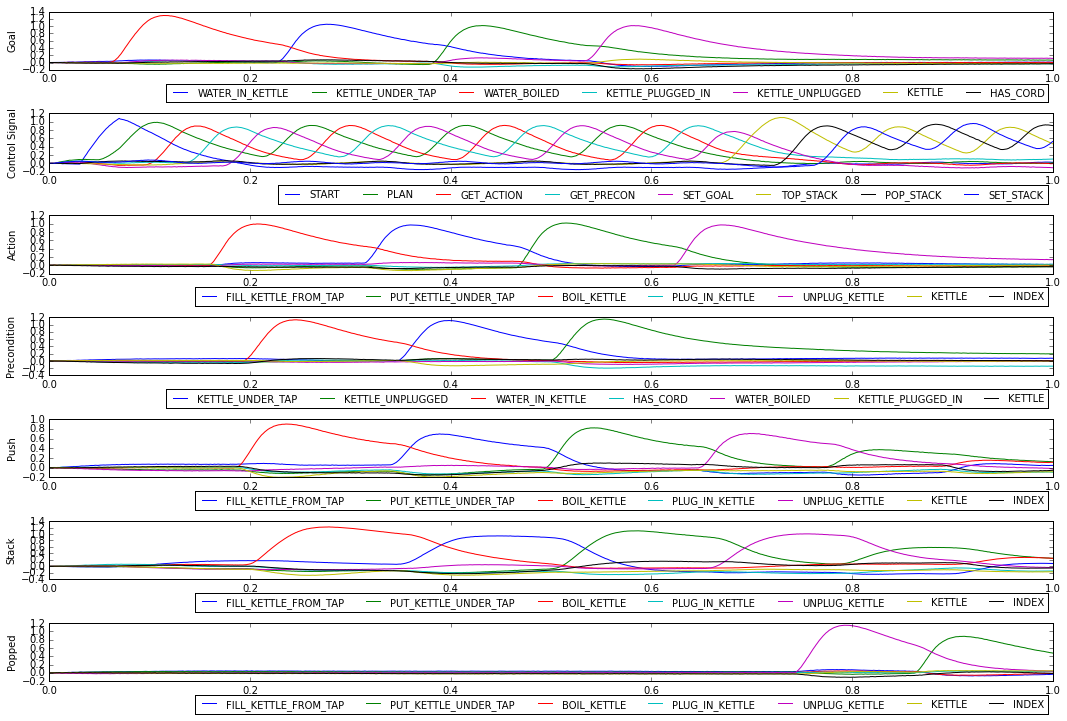

WATER
{'TEMPERATURE': 'COLD'}
------------------
KETTLE
{'PLUGGED': 'UNPLUGGED'}
UNDER-TAP
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


In [113]:
plot_results_full(sim)
test_world.print_state()

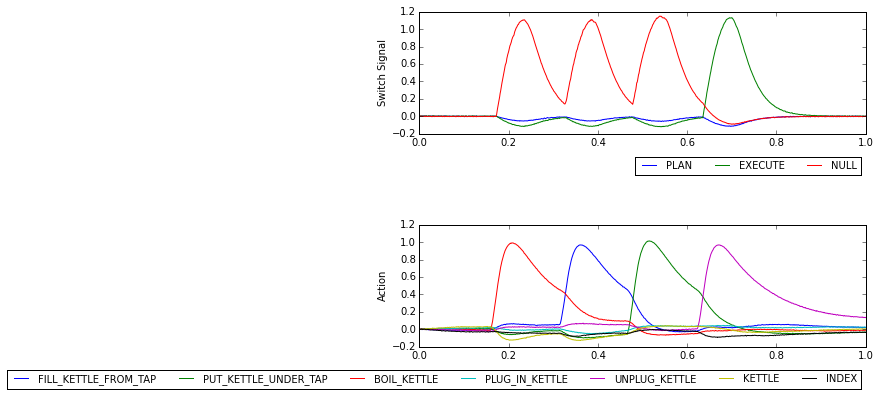

In [114]:
plot_additional(sim)